In [1]:
# Auto-Reload for Fast Iteration
%load_ext autoreload
%autoreload 2

# Add project root to sys.path
import sys
import os
sys.path.append(os.path.abspath('..'))

# Import from base_script.py (which is in the root folder)
from base_script import *

# Import custom functions from your utils package
from utils.models import VAE, CVAE

from utils.train_utils import (
    train_vae,
    loss_function,
    get_latent_mu,
    get_latent_mu_cvae,
    compute_condition_distances
)

from utils.data_utils import (
    load_all_fc_data,
    preprocess_for_torch
)

from utils.utils_plotting import (
    plot_vae_losses,
    plot_latent_embedding_by_condition_and_subject,
    plot_subject_distance_comparison
)


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sub_cond_path = '../subject_info.xlsx'
base_nifti_folder = '../data_FC'
condition_map = {'N': 0, 'S': 1, 'C': 2}

In [3]:
# Load and preprocess
use_roi = 0
all_corr_data, all_tms_type, all_subject_id, all_stimloc, all_session = load_all_fc_data(sub_cond_path, 
                                                               base_nifti_folder, 
                                                               mat_filename='conn_matrix_w_sphere.mat',
                                                               key_name='correlation_matrix',row_idx=use_roi)
# One-hot encode subject ID as condition
subject_arr = np.array(all_subject_id).reshape(-1, 1)
subject_encoder = OneHotEncoder(sparse_output=False, drop=None)
subject_ohe = subject_encoder.fit_transform(subject_arr)  # shape: [n_samples, n_subjects]

# Encode condition just for sampling
condition_list = np.array([condition_map[t] for t in all_tms_type])  # e.g., 'C' → 0, etc.

# Create combo keys for subject × TMS condition
combo_keys = np.array([f"{s}_{c}" for s, c in zip(all_subject_id, condition_list)])
combo_counts = Counter(combo_keys)

# Compute inverse weights for sampling
weights = np.array([1.0 / combo_counts[k] for k in combo_keys])
weights_tensor = torch.DoubleTensor(weights)

[WARN] File not found: ../data_FC/NODEAP_30/S3D2/conn_matrix_w_sphere.mat
[WARN] File not found: ../data_FC/NODEAP_44/S1D1/conn_matrix_w_sphere.mat
[WARN] File not found: ../data_FC/NODEAP_83/S3D1/conn_matrix_w_sphere.mat
[WARN] File not found: ../data_FC/NODEAP_87/D0/conn_matrix_w_sphere.mat
[WARN] File not found: ../data_FC/NODEAP_88/D0/conn_matrix_w_sphere.mat


In [4]:
# Convert to torch tensors
X_tensor = preprocess_for_torch(all_corr_data)  
subject_cond_tensor = torch.tensor(subject_ohe, dtype=torch.float32)
dataset = TensorDataset(X_tensor, subject_cond_tensor)

sampler = WeightedRandomSampler(weights_tensor, num_samples=len(weights_tensor), replacement=True)
dataloader = DataLoader(dataset, batch_size=32, sampler=sampler)

Columns with NaN: 14 / 116
Tensor shape after preprocessing: torch.Size([331, 102])


In [11]:
# Set up model, optimizer, and device
input_dim = X_tensor.shape[1]
cond_dim = subject_cond_tensor.shape[1]
latent_dim = 10
hidden_dim = 64 # 128 (64 for FC vector)  
model = CVAE(input_dim=input_dim, cond_dim=cond_dim, latent_dim=latent_dim, hidden_dim=hidden_dim).to(DEVICE)

In [12]:
NUM_EPOCH = 500
LR = 3e-4
le = LabelEncoder()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
total_loss_hist, recon_loss_hist, kld_loss_hist = train_vae(model, dataloader, optimizer, device=DEVICE, epochs=NUM_EPOCH, label_encoder=le, log_batch_info=True)


===== Epoch 1 =====


Epoch 1/500: 100%|█████████████████████████████| 11/11 [00:00<00:00, 704.55it/s]


Epoch 1, Loss: 97.1110, Recon: 96.8123, KL: 0.2986

===== Epoch 2 =====


Epoch 2/500: 100%|█████████████████████████████| 11/11 [00:00<00:00, 643.50it/s]


Epoch 2, Loss: 103.9395, Recon: 103.6665, KL: 0.2729

===== Epoch 3 =====


Epoch 3/500: 100%|█████████████████████████████| 11/11 [00:00<00:00, 653.78it/s]


Epoch 3, Loss: 105.0245, Recon: 104.6935, KL: 0.3310

===== Epoch 4 =====


Epoch 4/500: 100%|█████████████████████████████| 11/11 [00:00<00:00, 692.61it/s]


Epoch 4, Loss: 99.5393, Recon: 99.1712, KL: 0.3681

===== Epoch 5 =====


Epoch 5/500: 100%|█████████████████████████████| 11/11 [00:00<00:00, 897.44it/s]


Epoch 5, Loss: 102.0187, Recon: 101.4980, KL: 0.5207

===== Epoch 6 =====


Epoch 6/500: 100%|█████████████████████████████| 11/11 [00:00<00:00, 830.36it/s]


Epoch 6, Loss: 101.6692, Recon: 100.8871, KL: 0.7821

===== Epoch 7 =====


Epoch 7/500: 100%|█████████████████████████████| 11/11 [00:00<00:00, 813.12it/s]


Epoch 7, Loss: 98.9795, Recon: 97.8149, KL: 1.1646

===== Epoch 8 =====


Epoch 8/500: 100%|█████████████████████████████| 11/11 [00:00<00:00, 857.56it/s]


Epoch 8, Loss: 99.9799, Recon: 98.1831, KL: 1.7968

===== Epoch 9 =====


Epoch 9/500: 100%|█████████████████████████████| 11/11 [00:00<00:00, 813.32it/s]


Epoch 9, Loss: 95.7043, Recon: 92.5842, KL: 3.1201

===== Epoch 10 =====


Epoch 10/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 856.36it/s]


Epoch 10, Loss: 88.7772, Recon: 84.3839, KL: 4.3933

===== Epoch 11 =====


Epoch 11/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 767.03it/s]


Epoch 11, Loss: 91.7580, Recon: 85.3866, KL: 6.3714

===== Epoch 12 =====


Epoch 12/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 780.02it/s]


Epoch 12, Loss: 86.0412, Recon: 79.4208, KL: 6.6205

===== Epoch 13 =====


Epoch 13/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 931.24it/s]


Epoch 13, Loss: 77.8965, Recon: 71.0800, KL: 6.8165

===== Epoch 14 =====


Epoch 14/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 717.54it/s]


Epoch 14, Loss: 73.7984, Recon: 67.1975, KL: 6.6009

===== Epoch 15 =====


Epoch 15/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 834.73it/s]


Epoch 15, Loss: 76.4940, Recon: 68.5004, KL: 7.9936

===== Epoch 16 =====


Epoch 16/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 771.28it/s]


Epoch 16, Loss: 71.3192, Recon: 63.5577, KL: 7.7615

===== Epoch 17 =====


Epoch 17/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 743.73it/s]


Epoch 17, Loss: 76.9725, Recon: 68.1652, KL: 8.8073

===== Epoch 18 =====


Epoch 18/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 825.15it/s]


Epoch 18, Loss: 69.7935, Recon: 61.1777, KL: 8.6158

===== Epoch 19 =====


Epoch 19/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 758.19it/s]


Epoch 19, Loss: 71.0917, Recon: 62.7921, KL: 8.2996

===== Epoch 20 =====


Epoch 20/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 918.21it/s]


Epoch 20, Loss: 68.4733, Recon: 60.1095, KL: 8.3638

===== Epoch 21 =====


Epoch 21/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 858.43it/s]


Epoch 21, Loss: 64.5763, Recon: 56.5519, KL: 8.0245

===== Epoch 22 =====


Epoch 22/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 822.85it/s]


Epoch 22, Loss: 67.2019, Recon: 59.0865, KL: 8.1155

===== Epoch 23 =====


Epoch 23/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 737.22it/s]


Epoch 23, Loss: 64.5415, Recon: 56.2164, KL: 8.3252

===== Epoch 24 =====


Epoch 24/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 810.07it/s]


Epoch 24, Loss: 60.8062, Recon: 53.5851, KL: 7.2211

===== Epoch 25 =====


Epoch 25/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 914.23it/s]


Epoch 25, Loss: 61.3173, Recon: 53.3785, KL: 7.9388

===== Epoch 26 =====


Epoch 26/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1110.65it/s]


Epoch 26, Loss: 60.2726, Recon: 52.1181, KL: 8.1544

===== Epoch 27 =====


Epoch 27/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 706.80it/s]


Epoch 27, Loss: 59.8565, Recon: 53.0652, KL: 6.7912

===== Epoch 28 =====


Epoch 28/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 944.62it/s]


Epoch 28, Loss: 60.0156, Recon: 52.3848, KL: 7.6307

===== Epoch 29 =====


Epoch 29/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1044.73it/s]


Epoch 29, Loss: 60.4709, Recon: 52.0427, KL: 8.4282

===== Epoch 30 =====


Epoch 30/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 994.30it/s]


Epoch 30, Loss: 58.9968, Recon: 50.9300, KL: 8.0669

===== Epoch 31 =====


Epoch 31/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 972.93it/s]


Epoch 31, Loss: 59.7204, Recon: 51.6003, KL: 8.1201

===== Epoch 32 =====


Epoch 32/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 779.52it/s]


Epoch 32, Loss: 55.4283, Recon: 47.4633, KL: 7.9649

===== Epoch 33 =====


Epoch 33/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 978.92it/s]


Epoch 33, Loss: 59.4700, Recon: 51.3302, KL: 8.1398

===== Epoch 34 =====


Epoch 34/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 969.60it/s]


Epoch 34, Loss: 55.2426, Recon: 46.9777, KL: 8.2648

===== Epoch 35 =====


Epoch 35/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 963.30it/s]


Epoch 35, Loss: 57.3778, Recon: 49.0321, KL: 8.3457

===== Epoch 36 =====


Epoch 36/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 891.63it/s]


Epoch 36, Loss: 55.4225, Recon: 47.3082, KL: 8.1143

===== Epoch 37 =====


Epoch 37/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 985.42it/s]


Epoch 37, Loss: 56.3244, Recon: 47.8174, KL: 8.5070

===== Epoch 38 =====


Epoch 38/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 858.62it/s]


Epoch 38, Loss: 55.4256, Recon: 47.2523, KL: 8.1732

===== Epoch 39 =====


Epoch 39/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 924.67it/s]


Epoch 39, Loss: 55.4129, Recon: 47.4758, KL: 7.9371

===== Epoch 40 =====


Epoch 40/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1023.91it/s]


Epoch 40, Loss: 55.7751, Recon: 47.8579, KL: 7.9171

===== Epoch 41 =====


Epoch 41/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 971.64it/s]


Epoch 41, Loss: 56.3375, Recon: 47.8651, KL: 8.4724

===== Epoch 42 =====


Epoch 42/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 964.91it/s]


Epoch 42, Loss: 55.2863, Recon: 47.4078, KL: 7.8785

===== Epoch 43 =====


Epoch 43/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1066.29it/s]


Epoch 43, Loss: 53.3505, Recon: 45.5351, KL: 7.8154

===== Epoch 44 =====


Epoch 44/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 972.36it/s]


Epoch 44, Loss: 54.3147, Recon: 46.1288, KL: 8.1859

===== Epoch 45 =====


Epoch 45/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1057.18it/s]


Epoch 45, Loss: 53.6661, Recon: 46.2039, KL: 7.4622

===== Epoch 46 =====


Epoch 46/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1033.73it/s]


Epoch 46, Loss: 54.7651, Recon: 46.3831, KL: 8.3821

===== Epoch 47 =====


Epoch 47/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1080.58it/s]


Epoch 47, Loss: 53.3908, Recon: 45.6582, KL: 7.7326

===== Epoch 48 =====


Epoch 48/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1035.37it/s]


Epoch 48, Loss: 54.8729, Recon: 46.4831, KL: 8.3898

===== Epoch 49 =====


Epoch 49/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1068.14it/s]


Epoch 49, Loss: 52.0663, Recon: 44.3734, KL: 7.6929

===== Epoch 50 =====


Epoch 50/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1021.91it/s]


Epoch 50, Loss: 53.6440, Recon: 45.3702, KL: 8.2738

===== Epoch 51 =====


Epoch 51/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1141.79it/s]


Epoch 51, Loss: 53.2722, Recon: 44.8800, KL: 8.3922

===== Epoch 52 =====


Epoch 52/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1119.40it/s]


Epoch 52, Loss: 51.7587, Recon: 43.5799, KL: 8.1788

===== Epoch 53 =====


Epoch 53/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1064.25it/s]


Epoch 53, Loss: 51.3576, Recon: 43.7340, KL: 7.6236

===== Epoch 54 =====


Epoch 54/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1057.40it/s]


Epoch 54, Loss: 51.0667, Recon: 42.6903, KL: 8.3764

===== Epoch 55 =====


Epoch 55/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1114.59it/s]


Epoch 55, Loss: 49.2701, Recon: 41.4330, KL: 7.8372

===== Epoch 56 =====


Epoch 56/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1134.85it/s]


Epoch 56, Loss: 50.0664, Recon: 41.9486, KL: 8.1178

===== Epoch 57 =====


Epoch 57/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1157.28it/s]


Epoch 57, Loss: 50.5037, Recon: 42.1149, KL: 8.3888

===== Epoch 58 =====


Epoch 58/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 935.20it/s]


Epoch 58, Loss: 49.8210, Recon: 42.2864, KL: 7.5346

===== Epoch 59 =====


Epoch 59/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 677.54it/s]


Epoch 59, Loss: 53.0549, Recon: 45.0192, KL: 8.0357

===== Epoch 60 =====


Epoch 60/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 661.14it/s]


Epoch 60, Loss: 50.7828, Recon: 42.7459, KL: 8.0369

===== Epoch 61 =====


Epoch 61/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 995.03it/s]


Epoch 61, Loss: 49.5294, Recon: 40.6195, KL: 8.9099

===== Epoch 62 =====


Epoch 62/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1234.68it/s]


Epoch 62, Loss: 51.4638, Recon: 42.9097, KL: 8.5541

===== Epoch 63 =====


Epoch 63/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 842.80it/s]


Epoch 63, Loss: 50.2568, Recon: 41.8641, KL: 8.3927

===== Epoch 64 =====


Epoch 64/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1201.49it/s]


Epoch 64, Loss: 47.4773, Recon: 39.3581, KL: 8.1192

===== Epoch 65 =====


Epoch 65/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1179.29it/s]


Epoch 65, Loss: 47.9034, Recon: 40.2571, KL: 7.6463

===== Epoch 66 =====


Epoch 66/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1222.73it/s]


Epoch 66, Loss: 50.0308, Recon: 41.8240, KL: 8.2068

===== Epoch 67 =====


Epoch 67/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1175.20it/s]


Epoch 67, Loss: 49.3102, Recon: 40.5716, KL: 8.7385

===== Epoch 68 =====


Epoch 68/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1163.91it/s]


Epoch 68, Loss: 49.4890, Recon: 41.1673, KL: 8.3217

===== Epoch 69 =====


Epoch 69/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1103.08it/s]


Epoch 69, Loss: 45.8926, Recon: 38.1241, KL: 7.7685

===== Epoch 70 =====


Epoch 70/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1122.56it/s]


Epoch 70, Loss: 47.3482, Recon: 39.5768, KL: 7.7713

===== Epoch 71 =====


Epoch 71/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1117.32it/s]


Epoch 71, Loss: 47.1591, Recon: 39.0302, KL: 8.1288

===== Epoch 72 =====


Epoch 72/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1232.50it/s]


Epoch 72, Loss: 51.0008, Recon: 42.2342, KL: 8.7666

===== Epoch 73 =====


Epoch 73/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1114.59it/s]


Epoch 73, Loss: 48.2241, Recon: 39.6871, KL: 8.5369

===== Epoch 74 =====


Epoch 74/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1196.01it/s]


Epoch 74, Loss: 48.3358, Recon: 39.6499, KL: 8.6859

===== Epoch 75 =====


Epoch 75/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1176.19it/s]


Epoch 75, Loss: 48.2920, Recon: 39.7690, KL: 8.5231

===== Epoch 76 =====


Epoch 76/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1234.71it/s]


Epoch 76, Loss: 49.8771, Recon: 40.7707, KL: 9.1064

===== Epoch 77 =====


Epoch 77/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1277.58it/s]


Epoch 77, Loss: 47.5082, Recon: 38.6319, KL: 8.8763

===== Epoch 78 =====


Epoch 78/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1270.23it/s]


Epoch 78, Loss: 49.2467, Recon: 40.7188, KL: 8.5279

===== Epoch 79 =====


Epoch 79/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1234.54it/s]


Epoch 79, Loss: 49.8110, Recon: 41.3814, KL: 8.4296

===== Epoch 80 =====


Epoch 80/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1289.40it/s]


Epoch 80, Loss: 49.0424, Recon: 40.1553, KL: 8.8870

===== Epoch 81 =====


Epoch 81/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1255.47it/s]


Epoch 81, Loss: 47.8445, Recon: 39.5652, KL: 8.2793

===== Epoch 82 =====


Epoch 82/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1312.66it/s]


Epoch 82, Loss: 45.1993, Recon: 36.8570, KL: 8.3424

===== Epoch 83 =====


Epoch 83/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1093.66it/s]


Epoch 83, Loss: 47.9979, Recon: 39.5226, KL: 8.4753

===== Epoch 84 =====


Epoch 84/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1218.18it/s]


Epoch 84, Loss: 47.5872, Recon: 39.2816, KL: 8.3056

===== Epoch 85 =====


Epoch 85/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1151.88it/s]


Epoch 85, Loss: 46.8453, Recon: 38.3699, KL: 8.4753

===== Epoch 86 =====


Epoch 86/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1138.69it/s]


Epoch 86, Loss: 50.0474, Recon: 40.9128, KL: 9.1346

===== Epoch 87 =====


Epoch 87/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1163.38it/s]


Epoch 87, Loss: 45.5558, Recon: 37.2497, KL: 8.3061

===== Epoch 88 =====


Epoch 88/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1209.97it/s]


Epoch 88, Loss: 45.2480, Recon: 36.6897, KL: 8.5583

===== Epoch 89 =====


Epoch 89/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1195.24it/s]


Epoch 89, Loss: 44.7519, Recon: 36.3688, KL: 8.3830

===== Epoch 90 =====


Epoch 90/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1180.89it/s]


Epoch 90, Loss: 44.9252, Recon: 36.0689, KL: 8.8564

===== Epoch 91 =====


Epoch 91/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1262.93it/s]


Epoch 91, Loss: 44.1700, Recon: 35.8608, KL: 8.3092

===== Epoch 92 =====


Epoch 92/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1183.04it/s]


Epoch 92, Loss: 44.9106, Recon: 36.0729, KL: 8.8377

===== Epoch 93 =====


Epoch 93/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1223.45it/s]


Epoch 93, Loss: 43.8930, Recon: 35.4369, KL: 8.4561

===== Epoch 94 =====


Epoch 94/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1186.75it/s]


Epoch 94, Loss: 44.7083, Recon: 35.8950, KL: 8.8133

===== Epoch 95 =====


Epoch 95/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1220.34it/s]


Epoch 95, Loss: 44.4288, Recon: 35.4244, KL: 9.0044

===== Epoch 96 =====


Epoch 96/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1235.97it/s]


Epoch 96, Loss: 44.7908, Recon: 35.6556, KL: 9.1352

===== Epoch 97 =====


Epoch 97/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1207.72it/s]


Epoch 97, Loss: 44.2837, Recon: 35.4659, KL: 8.8178

===== Epoch 98 =====


Epoch 98/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1217.92it/s]


Epoch 98, Loss: 43.7914, Recon: 34.8032, KL: 8.9882

===== Epoch 99 =====


Epoch 99/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1085.87it/s]


Epoch 99, Loss: 44.2600, Recon: 35.0977, KL: 9.1623

===== Epoch 100 =====


Epoch 100/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1066.81it/s]


Epoch 100, Loss: 42.8394, Recon: 33.5934, KL: 9.2461

===== Epoch 101 =====


Epoch 101/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1044.52it/s]


Epoch 101, Loss: 44.0608, Recon: 34.9727, KL: 9.0881

===== Epoch 102 =====


Epoch 102/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1197.84it/s]


Epoch 102, Loss: 42.5593, Recon: 33.2704, KL: 9.2890

===== Epoch 103 =====


Epoch 103/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1083.72it/s]


Epoch 103, Loss: 42.8563, Recon: 33.4695, KL: 9.3868

===== Epoch 104 =====


Epoch 104/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1091.05it/s]


Epoch 104, Loss: 43.5977, Recon: 34.4662, KL: 9.1316

===== Epoch 105 =====


Epoch 105/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1333.53it/s]


Epoch 105, Loss: 41.3159, Recon: 32.5362, KL: 8.7797

===== Epoch 106 =====


Epoch 106/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1115.48it/s]


Epoch 106, Loss: 42.5560, Recon: 33.6270, KL: 8.9290

===== Epoch 107 =====


Epoch 107/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1141.42it/s]


Epoch 107, Loss: 41.1842, Recon: 32.3998, KL: 8.7843

===== Epoch 108 =====


Epoch 108/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1133.57it/s]


Epoch 108, Loss: 41.5164, Recon: 32.2963, KL: 9.2200

===== Epoch 109 =====


Epoch 109/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1328.65it/s]


Epoch 109, Loss: 42.0149, Recon: 32.6478, KL: 9.3671

===== Epoch 110 =====


Epoch 110/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1050.34it/s]


Epoch 110, Loss: 43.0781, Recon: 33.9765, KL: 9.1017

===== Epoch 111 =====


Epoch 111/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1106.78it/s]


Epoch 111, Loss: 41.7251, Recon: 32.8939, KL: 8.8313

===== Epoch 112 =====


Epoch 112/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1168.86it/s]


Epoch 112, Loss: 40.8771, Recon: 31.8468, KL: 9.0303

===== Epoch 113 =====


Epoch 113/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1130.29it/s]


Epoch 113, Loss: 42.0501, Recon: 32.7253, KL: 9.3248

===== Epoch 114 =====


Epoch 114/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1123.71it/s]


Epoch 114, Loss: 42.4613, Recon: 33.1245, KL: 9.3368

===== Epoch 115 =====


Epoch 115/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1208.80it/s]


Epoch 115, Loss: 42.1659, Recon: 32.2890, KL: 9.8769

===== Epoch 116 =====


Epoch 116/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1165.50it/s]


Epoch 116, Loss: 42.3742, Recon: 32.7449, KL: 9.6292

===== Epoch 117 =====


Epoch 117/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1168.71it/s]


Epoch 117, Loss: 41.6070, Recon: 32.1250, KL: 9.4820

===== Epoch 118 =====


Epoch 118/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1223.74it/s]


Epoch 118, Loss: 41.5360, Recon: 31.6500, KL: 9.8861

===== Epoch 119 =====


Epoch 119/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1307.38it/s]


Epoch 119, Loss: 41.4566, Recon: 32.1861, KL: 9.2705

===== Epoch 120 =====


Epoch 120/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1192.83it/s]


Epoch 120, Loss: 41.2293, Recon: 31.9877, KL: 9.2416

===== Epoch 121 =====


Epoch 121/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1204.44it/s]


Epoch 121, Loss: 41.2753, Recon: 31.7540, KL: 9.5213

===== Epoch 122 =====


Epoch 122/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1151.71it/s]


Epoch 122, Loss: 41.9622, Recon: 32.2889, KL: 9.6733

===== Epoch 123 =====


Epoch 123/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1369.71it/s]


Epoch 123, Loss: 39.7757, Recon: 30.5580, KL: 9.2177

===== Epoch 124 =====


Epoch 124/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1135.07it/s]


Epoch 124, Loss: 40.5036, Recon: 30.9548, KL: 9.5488

===== Epoch 125 =====


Epoch 125/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1256.29it/s]


Epoch 125, Loss: 40.8433, Recon: 31.5692, KL: 9.2741

===== Epoch 126 =====


Epoch 126/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1209.34it/s]


Epoch 126, Loss: 40.1981, Recon: 30.6502, KL: 9.5479

===== Epoch 127 =====


Epoch 127/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1266.57it/s]


Epoch 127, Loss: 41.3555, Recon: 31.5007, KL: 9.8548

===== Epoch 128 =====


Epoch 128/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1199.18it/s]


Epoch 128, Loss: 40.0302, Recon: 30.7316, KL: 9.2986

===== Epoch 129 =====


Epoch 129/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1288.32it/s]


Epoch 129, Loss: 39.4152, Recon: 30.2859, KL: 9.1293

===== Epoch 130 =====


Epoch 130/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1256.70it/s]


Epoch 130, Loss: 40.8991, Recon: 31.4744, KL: 9.4247

===== Epoch 131 =====


Epoch 131/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1250.30it/s]


Epoch 131, Loss: 39.9977, Recon: 30.5346, KL: 9.4631

===== Epoch 132 =====


Epoch 132/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1274.79it/s]


Epoch 132, Loss: 40.3878, Recon: 30.6153, KL: 9.7725

===== Epoch 133 =====


Epoch 133/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1289.91it/s]


Epoch 133, Loss: 39.9827, Recon: 30.5294, KL: 9.4533

===== Epoch 134 =====


Epoch 134/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1248.27it/s]


Epoch 134, Loss: 38.9130, Recon: 29.6442, KL: 9.2688

===== Epoch 135 =====


Epoch 135/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1271.25it/s]


Epoch 135, Loss: 38.4209, Recon: 29.0574, KL: 9.3634

===== Epoch 136 =====


Epoch 136/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1311.09it/s]


Epoch 136, Loss: 38.4088, Recon: 29.2429, KL: 9.1660

===== Epoch 137 =====


Epoch 137/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1294.72it/s]


Epoch 137, Loss: 39.9885, Recon: 30.4637, KL: 9.5248

===== Epoch 138 =====


Epoch 138/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1244.37it/s]


Epoch 138, Loss: 39.4968, Recon: 29.5419, KL: 9.9548

===== Epoch 139 =====


Epoch 139/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1213.06it/s]


Epoch 139, Loss: 39.0926, Recon: 29.9518, KL: 9.1407

===== Epoch 140 =====


Epoch 140/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1305.20it/s]


Epoch 140, Loss: 38.1926, Recon: 28.4220, KL: 9.7706

===== Epoch 141 =====


Epoch 141/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1313.89it/s]


Epoch 141, Loss: 37.9026, Recon: 28.5715, KL: 9.3310

===== Epoch 142 =====


Epoch 142/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1305.45it/s]


Epoch 142, Loss: 38.5418, Recon: 29.3155, KL: 9.2263

===== Epoch 143 =====


Epoch 143/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1344.76it/s]


Epoch 143, Loss: 38.0845, Recon: 28.5489, KL: 9.5356

===== Epoch 144 =====


Epoch 144/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1311.35it/s]


Epoch 144, Loss: 38.2884, Recon: 28.8306, KL: 9.4578

===== Epoch 145 =====


Epoch 145/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1312.17it/s]


Epoch 145, Loss: 39.6829, Recon: 30.0238, KL: 9.6591

===== Epoch 146 =====


Epoch 146/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1318.32it/s]


Epoch 146, Loss: 39.8837, Recon: 29.9831, KL: 9.9006

===== Epoch 147 =====


Epoch 147/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1298.55it/s]


Epoch 147, Loss: 38.4602, Recon: 29.1021, KL: 9.3581

===== Epoch 148 =====


Epoch 148/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1285.02it/s]


Epoch 148, Loss: 38.2947, Recon: 28.6063, KL: 9.6883

===== Epoch 149 =====


Epoch 149/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1151.33it/s]


Epoch 149, Loss: 37.4411, Recon: 28.0523, KL: 9.3888

===== Epoch 150 =====


Epoch 150/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1116.75it/s]


Epoch 150, Loss: 39.3509, Recon: 29.6738, KL: 9.6771

===== Epoch 151 =====


Epoch 151/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1148.61it/s]


Epoch 151, Loss: 38.0977, Recon: 28.3364, KL: 9.7613

===== Epoch 152 =====


Epoch 152/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1087.81it/s]


Epoch 152, Loss: 38.1650, Recon: 28.4604, KL: 9.7045

===== Epoch 153 =====


Epoch 153/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1155.95it/s]


Epoch 153, Loss: 38.3881, Recon: 28.4810, KL: 9.9071

===== Epoch 154 =====


Epoch 154/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1067.75it/s]


Epoch 154, Loss: 38.4475, Recon: 28.8564, KL: 9.5911

===== Epoch 155 =====


Epoch 155/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1128.22it/s]


Epoch 155, Loss: 37.3602, Recon: 28.0457, KL: 9.3145

===== Epoch 156 =====


Epoch 156/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1217.76it/s]


Epoch 156, Loss: 37.0164, Recon: 27.3117, KL: 9.7047

===== Epoch 157 =====


Epoch 157/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1137.28it/s]


Epoch 157, Loss: 37.7879, Recon: 28.2390, KL: 9.5489

===== Epoch 158 =====


Epoch 158/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1100.03it/s]


Epoch 158, Loss: 38.0909, Recon: 28.0649, KL: 10.0259

===== Epoch 159 =====


Epoch 159/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1123.93it/s]


Epoch 159, Loss: 36.9287, Recon: 27.4625, KL: 9.4663

===== Epoch 160 =====


Epoch 160/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1135.44it/s]


Epoch 160, Loss: 36.5899, Recon: 27.1967, KL: 9.3931

===== Epoch 161 =====


Epoch 161/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1178.51it/s]


Epoch 161, Loss: 36.4995, Recon: 27.2111, KL: 9.2884

===== Epoch 162 =====


Epoch 162/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1136.28it/s]


Epoch 162, Loss: 38.1809, Recon: 28.5483, KL: 9.6326

===== Epoch 163 =====


Epoch 163/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 963.48it/s]


Epoch 163, Loss: 36.5423, Recon: 26.9858, KL: 9.5565

===== Epoch 164 =====


Epoch 164/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1078.93it/s]


Epoch 164, Loss: 35.6511, Recon: 26.4006, KL: 9.2505

===== Epoch 165 =====


Epoch 165/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1193.04it/s]


Epoch 165, Loss: 39.4664, Recon: 29.4047, KL: 10.0616

===== Epoch 166 =====


Epoch 166/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1140.01it/s]


Epoch 166, Loss: 36.2351, Recon: 26.4815, KL: 9.7536

===== Epoch 167 =====


Epoch 167/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1097.38it/s]


Epoch 167, Loss: 37.0122, Recon: 27.3389, KL: 9.6733

===== Epoch 168 =====


Epoch 168/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1097.23it/s]


Epoch 168, Loss: 36.8557, Recon: 27.2098, KL: 9.6459

===== Epoch 169 =====


Epoch 169/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1099.21it/s]


Epoch 169, Loss: 37.1126, Recon: 27.2034, KL: 9.9091

===== Epoch 170 =====


Epoch 170/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1112.12it/s]


Epoch 170, Loss: 36.8095, Recon: 27.2007, KL: 9.6088

===== Epoch 171 =====


Epoch 171/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1108.99it/s]


Epoch 171, Loss: 35.4103, Recon: 26.4156, KL: 8.9947

===== Epoch 172 =====


Epoch 172/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1236.10it/s]


Epoch 172, Loss: 37.4463, Recon: 27.5987, KL: 9.8476

===== Epoch 173 =====


Epoch 173/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1222.73it/s]


Epoch 173, Loss: 36.2034, Recon: 26.3535, KL: 9.8499

===== Epoch 174 =====


Epoch 174/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1171.09it/s]


Epoch 174, Loss: 37.5822, Recon: 27.8093, KL: 9.7729

===== Epoch 175 =====


Epoch 175/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1198.65it/s]


Epoch 175, Loss: 35.1512, Recon: 25.8769, KL: 9.2743

===== Epoch 176 =====


Epoch 176/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1227.91it/s]


Epoch 176, Loss: 36.0974, Recon: 26.3844, KL: 9.7130

===== Epoch 177 =====


Epoch 177/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1198.78it/s]


Epoch 177, Loss: 35.9439, Recon: 26.5790, KL: 9.3649

===== Epoch 178 =====


Epoch 178/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1265.98it/s]


Epoch 178, Loss: 37.5251, Recon: 27.7084, KL: 9.8166

===== Epoch 179 =====


Epoch 179/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1273.46it/s]


Epoch 179, Loss: 36.9349, Recon: 26.8957, KL: 10.0392

===== Epoch 180 =====


Epoch 180/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1277.16it/s]


Epoch 180, Loss: 36.4721, Recon: 26.8701, KL: 9.6021

===== Epoch 181 =====


Epoch 181/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1277.12it/s]

Epoch 181, Loss: 35.5460, Recon: 26.0820, KL: 9.4640

===== Epoch 182 =====



Epoch 182/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1287.46it/s]


Epoch 182, Loss: 37.0998, Recon: 27.0455, KL: 10.0543

===== Epoch 183 =====


Epoch 183/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1194.25it/s]


Epoch 183, Loss: 35.4006, Recon: 25.7383, KL: 9.6622

===== Epoch 184 =====


Epoch 184/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1098.25it/s]


Epoch 184, Loss: 34.8264, Recon: 25.1961, KL: 9.6304

===== Epoch 185 =====


Epoch 185/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1138.74it/s]


Epoch 185, Loss: 35.4407, Recon: 25.8478, KL: 9.5929

===== Epoch 186 =====


Epoch 186/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1125.22it/s]


Epoch 186, Loss: 35.3109, Recon: 25.6339, KL: 9.6770

===== Epoch 187 =====


Epoch 187/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1099.87it/s]


Epoch 187, Loss: 36.3733, Recon: 26.6382, KL: 9.7351

===== Epoch 188 =====


Epoch 188/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1054.86it/s]


Epoch 188, Loss: 36.4191, Recon: 26.6227, KL: 9.7964

===== Epoch 189 =====


Epoch 189/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 966.79it/s]


Epoch 189, Loss: 35.8259, Recon: 26.0330, KL: 9.7929

===== Epoch 190 =====


Epoch 190/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1169.60it/s]


Epoch 190, Loss: 35.4965, Recon: 25.8677, KL: 9.6288

===== Epoch 191 =====


Epoch 191/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1142.15it/s]


Epoch 191, Loss: 35.1859, Recon: 25.8521, KL: 9.3338

===== Epoch 192 =====


Epoch 192/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1062.68it/s]


Epoch 192, Loss: 36.9673, Recon: 26.9653, KL: 10.0019

===== Epoch 193 =====


Epoch 193/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1145.25it/s]

Epoch 193, Loss: 34.5153, Recon: 24.7707, KL: 9.7446

===== Epoch 194 =====



Epoch 194/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1186.20it/s]


Epoch 194, Loss: 35.0153, Recon: 25.4684, KL: 9.5469

===== Epoch 195 =====


Epoch 195/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1241.42it/s]


Epoch 195, Loss: 36.2082, Recon: 26.4372, KL: 9.7710

===== Epoch 196 =====


Epoch 196/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1161.56it/s]


Epoch 196, Loss: 35.3704, Recon: 25.2731, KL: 10.0973

===== Epoch 197 =====


Epoch 197/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1291.89it/s]


Epoch 197, Loss: 35.4700, Recon: 25.4784, KL: 9.9916

===== Epoch 198 =====


Epoch 198/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1212.10it/s]


Epoch 198, Loss: 34.6114, Recon: 24.9233, KL: 9.6881

===== Epoch 199 =====


Epoch 199/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1183.07it/s]


Epoch 199, Loss: 34.1864, Recon: 24.5626, KL: 9.6238

===== Epoch 200 =====


Epoch 200/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1144.14it/s]


Epoch 200, Loss: 35.3666, Recon: 25.6554, KL: 9.7112

===== Epoch 201 =====


Epoch 201/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1228.63it/s]


Epoch 201, Loss: 35.4333, Recon: 25.7434, KL: 9.6899

===== Epoch 202 =====


Epoch 202/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1238.45it/s]


Epoch 202, Loss: 34.1114, Recon: 24.7630, KL: 9.3483

===== Epoch 203 =====


Epoch 203/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1290.01it/s]


Epoch 203, Loss: 34.9912, Recon: 25.4302, KL: 9.5610

===== Epoch 204 =====


Epoch 204/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1191.38it/s]


Epoch 204, Loss: 35.4445, Recon: 25.2937, KL: 10.1508

===== Epoch 205 =====


Epoch 205/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1296.83it/s]


Epoch 205, Loss: 35.9014, Recon: 26.0489, KL: 9.8525

===== Epoch 206 =====


Epoch 206/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1313.63it/s]


Epoch 206, Loss: 33.8423, Recon: 23.8432, KL: 9.9991

===== Epoch 207 =====


Epoch 207/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1294.14it/s]


Epoch 207, Loss: 33.7298, Recon: 23.9536, KL: 9.7762

===== Epoch 208 =====


Epoch 208/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1294.90it/s]


Epoch 208, Loss: 33.5085, Recon: 24.1619, KL: 9.3465

===== Epoch 209 =====


Epoch 209/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1267.86it/s]


Epoch 209, Loss: 34.5790, Recon: 24.7779, KL: 9.8011

===== Epoch 210 =====


Epoch 210/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1285.20it/s]


Epoch 210, Loss: 35.2357, Recon: 25.0510, KL: 10.1847

===== Epoch 211 =====


Epoch 211/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1302.54it/s]


Epoch 211, Loss: 34.5326, Recon: 24.7951, KL: 9.7375

===== Epoch 212 =====


Epoch 212/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1292.15it/s]


Epoch 212, Loss: 33.9896, Recon: 24.4283, KL: 9.5613

===== Epoch 213 =====


Epoch 213/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1305.93it/s]


Epoch 213, Loss: 33.3035, Recon: 23.9939, KL: 9.3096

===== Epoch 214 =====


Epoch 214/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1184.04it/s]


Epoch 214, Loss: 33.9178, Recon: 24.0331, KL: 9.8846

===== Epoch 215 =====


Epoch 215/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1283.13it/s]


Epoch 215, Loss: 33.5704, Recon: 23.7647, KL: 9.8057

===== Epoch 216 =====


Epoch 216/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1209.75it/s]


Epoch 216, Loss: 34.5325, Recon: 24.7640, KL: 9.7686

===== Epoch 217 =====


Epoch 217/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1244.63it/s]


Epoch 217, Loss: 33.9527, Recon: 24.1579, KL: 9.7947

===== Epoch 218 =====


Epoch 218/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1248.98it/s]


Epoch 218, Loss: 34.1633, Recon: 24.6435, KL: 9.5198

===== Epoch 219 =====


Epoch 219/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1098.01it/s]


Epoch 219, Loss: 34.3142, Recon: 24.1928, KL: 10.1214

===== Epoch 220 =====


Epoch 220/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1136.39it/s]


Epoch 220, Loss: 33.0388, Recon: 23.3345, KL: 9.7044

===== Epoch 221 =====


Epoch 221/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1123.14it/s]


Epoch 221, Loss: 34.4617, Recon: 24.7655, KL: 9.6962

===== Epoch 222 =====


Epoch 222/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1205.48it/s]


Epoch 222, Loss: 33.9977, Recon: 24.6234, KL: 9.3743

===== Epoch 223 =====


Epoch 223/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1017.38it/s]


Epoch 223, Loss: 34.1052, Recon: 23.8660, KL: 10.2391

===== Epoch 224 =====


Epoch 224/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1262.90it/s]


Epoch 224, Loss: 34.7267, Recon: 25.0199, KL: 9.7068

===== Epoch 225 =====


Epoch 225/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1213.06it/s]


Epoch 225, Loss: 33.7515, Recon: 23.9377, KL: 9.8138

===== Epoch 226 =====


Epoch 226/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1085.15it/s]


Epoch 226, Loss: 33.2308, Recon: 23.7446, KL: 9.4863

===== Epoch 227 =====


Epoch 227/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1127.39it/s]


Epoch 227, Loss: 33.3688, Recon: 23.5977, KL: 9.7711

===== Epoch 228 =====


Epoch 228/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1207.75it/s]


Epoch 228, Loss: 33.7901, Recon: 24.1443, KL: 9.6458

===== Epoch 229 =====


Epoch 229/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1197.75it/s]


Epoch 229, Loss: 32.2063, Recon: 23.1082, KL: 9.0980

===== Epoch 230 =====


Epoch 230/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1237.76it/s]


Epoch 230, Loss: 33.3171, Recon: 23.8061, KL: 9.5110

===== Epoch 231 =====


Epoch 231/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1339.06it/s]


Epoch 231, Loss: 33.3693, Recon: 23.4689, KL: 9.9005

===== Epoch 232 =====


Epoch 232/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1262.20it/s]


Epoch 232, Loss: 33.7487, Recon: 24.2498, KL: 9.4989

===== Epoch 233 =====


Epoch 233/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1251.69it/s]


Epoch 233, Loss: 32.7135, Recon: 23.2680, KL: 9.4455

===== Epoch 234 =====


Epoch 234/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1272.09it/s]


Epoch 234, Loss: 34.6019, Recon: 24.6451, KL: 9.9568

===== Epoch 235 =====


Epoch 235/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1303.35it/s]


Epoch 235, Loss: 33.4520, Recon: 23.7965, KL: 9.6554

===== Epoch 236 =====


Epoch 236/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1251.42it/s]


Epoch 236, Loss: 31.6263, Recon: 22.2887, KL: 9.3376

===== Epoch 237 =====


Epoch 237/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1329.15it/s]


Epoch 237, Loss: 33.4649, Recon: 23.7389, KL: 9.7260

===== Epoch 238 =====


Epoch 238/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1314.72it/s]


Epoch 238, Loss: 33.0867, Recon: 23.8082, KL: 9.2785

===== Epoch 239 =====


Epoch 239/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1299.97it/s]


Epoch 239, Loss: 32.5049, Recon: 23.1051, KL: 9.3999

===== Epoch 240 =====


Epoch 240/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1110.65it/s]


Epoch 240, Loss: 33.4900, Recon: 23.9998, KL: 9.4902

===== Epoch 241 =====


Epoch 241/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1175.95it/s]


Epoch 241, Loss: 32.9597, Recon: 23.4278, KL: 9.5319

===== Epoch 242 =====


Epoch 242/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1213.18it/s]


Epoch 242, Loss: 32.3819, Recon: 22.6931, KL: 9.6888

===== Epoch 243 =====


Epoch 243/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1257.29it/s]


Epoch 243, Loss: 33.0378, Recon: 23.4921, KL: 9.5457

===== Epoch 244 =====


Epoch 244/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1236.10it/s]


Epoch 244, Loss: 33.1026, Recon: 23.5101, KL: 9.5925

===== Epoch 245 =====


Epoch 245/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1263.48it/s]


Epoch 245, Loss: 32.4883, Recon: 22.9373, KL: 9.5510

===== Epoch 246 =====


Epoch 246/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1241.55it/s]


Epoch 246, Loss: 33.5407, Recon: 23.9744, KL: 9.5663

===== Epoch 247 =====


Epoch 247/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1271.07it/s]


Epoch 247, Loss: 31.8505, Recon: 22.5318, KL: 9.3188

===== Epoch 248 =====


Epoch 248/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1228.40it/s]


Epoch 248, Loss: 32.4041, Recon: 22.8158, KL: 9.5882

===== Epoch 249 =====


Epoch 249/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1266.57it/s]


Epoch 249, Loss: 31.9136, Recon: 22.4963, KL: 9.4173

===== Epoch 250 =====


Epoch 250/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1199.06it/s]


Epoch 250, Loss: 33.1587, Recon: 23.0345, KL: 10.1243

===== Epoch 251 =====


Epoch 251/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1155.60it/s]


Epoch 251, Loss: 32.2908, Recon: 22.7364, KL: 9.5545

===== Epoch 252 =====


Epoch 252/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1159.61it/s]


Epoch 252, Loss: 32.4248, Recon: 22.7120, KL: 9.7127

===== Epoch 253 =====


Epoch 253/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1190.24it/s]


Epoch 253, Loss: 32.5157, Recon: 22.7611, KL: 9.7546

===== Epoch 254 =====


Epoch 254/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1165.97it/s]


Epoch 254, Loss: 32.2679, Recon: 22.8530, KL: 9.4148

===== Epoch 255 =====


Epoch 255/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1149.44it/s]


Epoch 255, Loss: 32.4473, Recon: 23.1715, KL: 9.2758

===== Epoch 256 =====


Epoch 256/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1321.31it/s]


Epoch 256, Loss: 31.7945, Recon: 22.3460, KL: 9.4485

===== Epoch 257 =====


Epoch 257/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1322.71it/s]


Epoch 257, Loss: 32.0698, Recon: 22.8906, KL: 9.1791

===== Epoch 258 =====


Epoch 258/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1148.35it/s]


Epoch 258, Loss: 32.5561, Recon: 22.8532, KL: 9.7029

===== Epoch 259 =====


Epoch 259/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1147.27it/s]


Epoch 259, Loss: 32.5179, Recon: 23.0821, KL: 9.4358

===== Epoch 260 =====


Epoch 260/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1187.15it/s]


Epoch 260, Loss: 31.9462, Recon: 22.5763, KL: 9.3698

===== Epoch 261 =====


Epoch 261/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1226.31it/s]


Epoch 261, Loss: 32.4889, Recon: 22.9350, KL: 9.5539

===== Epoch 262 =====


Epoch 262/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1191.87it/s]


Epoch 262, Loss: 32.1104, Recon: 22.4980, KL: 9.6125

===== Epoch 263 =====


Epoch 263/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1190.49it/s]


Epoch 263, Loss: 31.7093, Recon: 22.1059, KL: 9.6034

===== Epoch 264 =====


Epoch 264/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1229.21it/s]


Epoch 264, Loss: 31.9856, Recon: 22.6056, KL: 9.3801

===== Epoch 265 =====


Epoch 265/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1271.95it/s]


Epoch 265, Loss: 32.1178, Recon: 22.4583, KL: 9.6595

===== Epoch 266 =====


Epoch 266/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1195.52it/s]


Epoch 266, Loss: 30.6669, Recon: 21.6546, KL: 9.0124

===== Epoch 267 =====


Epoch 267/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1170.32it/s]


Epoch 267, Loss: 31.2283, Recon: 21.7562, KL: 9.4722

===== Epoch 268 =====


Epoch 268/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1196.01it/s]


Epoch 268, Loss: 32.6210, Recon: 23.0647, KL: 9.5563

===== Epoch 269 =====


Epoch 269/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1167.00it/s]


Epoch 269, Loss: 31.9401, Recon: 22.2987, KL: 9.6414

===== Epoch 270 =====


Epoch 270/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1229.18it/s]


Epoch 270, Loss: 31.8744, Recon: 22.2805, KL: 9.5939

===== Epoch 271 =====


Epoch 271/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1252.17it/s]


Epoch 271, Loss: 31.7657, Recon: 22.1165, KL: 9.6492

===== Epoch 272 =====


Epoch 272/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1224.39it/s]


Epoch 272, Loss: 31.4614, Recon: 21.9517, KL: 9.5097

===== Epoch 273 =====


Epoch 273/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1197.22it/s]


Epoch 273, Loss: 32.0545, Recon: 22.7045, KL: 9.3500

===== Epoch 274 =====


Epoch 274/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1153.03it/s]


Epoch 274, Loss: 32.9301, Recon: 23.0638, KL: 9.8662

===== Epoch 275 =====


Epoch 275/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1206.80it/s]


Epoch 275, Loss: 32.5986, Recon: 22.8572, KL: 9.7414

===== Epoch 276 =====


Epoch 276/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1140.74it/s]


Epoch 276, Loss: 31.6647, Recon: 22.1301, KL: 9.5346

===== Epoch 277 =====


Epoch 277/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1187.03it/s]


Epoch 277, Loss: 32.0223, Recon: 22.3578, KL: 9.6645

===== Epoch 278 =====


Epoch 278/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1160.10it/s]


Epoch 278, Loss: 31.8647, Recon: 22.1758, KL: 9.6890

===== Epoch 279 =====


Epoch 279/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1254.14it/s]


Epoch 279, Loss: 32.0793, Recon: 22.4380, KL: 9.6413

===== Epoch 280 =====


Epoch 280/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1291.06it/s]


Epoch 280, Loss: 32.4075, Recon: 22.7974, KL: 9.6101

===== Epoch 281 =====


Epoch 281/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1212.90it/s]


Epoch 281, Loss: 31.9266, Recon: 22.2522, KL: 9.6745

===== Epoch 282 =====


Epoch 282/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1083.54it/s]


Epoch 282, Loss: 32.1004, Recon: 22.3711, KL: 9.7293

===== Epoch 283 =====


Epoch 283/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 965.84it/s]


Epoch 283, Loss: 31.4980, Recon: 22.0249, KL: 9.4730

===== Epoch 284 =====


Epoch 284/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1057.15it/s]


Epoch 284, Loss: 31.5746, Recon: 21.8899, KL: 9.6847

===== Epoch 285 =====


Epoch 285/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 991.18it/s]


Epoch 285, Loss: 31.0904, Recon: 21.5830, KL: 9.5074

===== Epoch 286 =====


Epoch 286/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1113.81it/s]


Epoch 286, Loss: 30.7815, Recon: 21.3273, KL: 9.4541

===== Epoch 287 =====


Epoch 287/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1071.47it/s]


Epoch 287, Loss: 30.5805, Recon: 21.4085, KL: 9.1719

===== Epoch 288 =====


Epoch 288/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1028.80it/s]


Epoch 288, Loss: 31.9913, Recon: 22.1854, KL: 9.8059

===== Epoch 289 =====


Epoch 289/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1123.96it/s]


Epoch 289, Loss: 30.7717, Recon: 21.3394, KL: 9.4323

===== Epoch 290 =====


Epoch 290/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1165.00it/s]


Epoch 290, Loss: 31.2541, Recon: 21.7828, KL: 9.4713

===== Epoch 291 =====


Epoch 291/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 963.28it/s]


Epoch 291, Loss: 31.1804, Recon: 22.0693, KL: 9.1111

===== Epoch 292 =====


Epoch 292/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1083.21it/s]


Epoch 292, Loss: 30.2606, Recon: 21.0624, KL: 9.1983

===== Epoch 293 =====


Epoch 293/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1140.15it/s]


Epoch 293, Loss: 30.8480, Recon: 21.2031, KL: 9.6449

===== Epoch 294 =====


Epoch 294/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1195.39it/s]


Epoch 294, Loss: 31.6198, Recon: 21.9418, KL: 9.6779

===== Epoch 295 =====


Epoch 295/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1104.19it/s]


Epoch 295, Loss: 31.7462, Recon: 22.1991, KL: 9.5471

===== Epoch 296 =====


Epoch 296/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 861.82it/s]


Epoch 296, Loss: 31.0408, Recon: 21.5118, KL: 9.5291

===== Epoch 297 =====


Epoch 297/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 978.56it/s]


Epoch 297, Loss: 31.1042, Recon: 21.6809, KL: 9.4234

===== Epoch 298 =====


Epoch 298/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 209.61it/s]


Epoch 298, Loss: 30.8333, Recon: 21.3366, KL: 9.4967

===== Epoch 299 =====


Epoch 299/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 552.24it/s]


Epoch 299, Loss: 30.1965, Recon: 20.7201, KL: 9.4764

===== Epoch 300 =====


Epoch 300/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1209.21it/s]


Epoch 300, Loss: 32.0509, Recon: 22.3762, KL: 9.6747

===== Epoch 301 =====


Epoch 301/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1237.46it/s]


Epoch 301, Loss: 31.5253, Recon: 22.0976, KL: 9.4278

===== Epoch 302 =====


Epoch 302/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1272.44it/s]


Epoch 302, Loss: 29.6039, Recon: 20.3862, KL: 9.2177

===== Epoch 303 =====


Epoch 303/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1249.86it/s]


Epoch 303, Loss: 29.8888, Recon: 20.8460, KL: 9.0428

===== Epoch 304 =====


Epoch 304/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1169.99it/s]


Epoch 304, Loss: 30.0273, Recon: 20.5687, KL: 9.4587

===== Epoch 305 =====


Epoch 305/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1201.65it/s]


Epoch 305, Loss: 31.3192, Recon: 21.4609, KL: 9.8582

===== Epoch 306 =====


Epoch 306/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1160.08it/s]


Epoch 306, Loss: 31.0202, Recon: 21.4880, KL: 9.5322

===== Epoch 307 =====


Epoch 307/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1256.98it/s]


Epoch 307, Loss: 29.8315, Recon: 20.6976, KL: 9.1340

===== Epoch 308 =====


Epoch 308/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1236.26it/s]


Epoch 308, Loss: 30.1878, Recon: 20.7071, KL: 9.4807

===== Epoch 309 =====


Epoch 309/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1293.67it/s]


Epoch 309, Loss: 29.5388, Recon: 20.1207, KL: 9.4181

===== Epoch 310 =====


Epoch 310/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1349.83it/s]


Epoch 310, Loss: 31.0041, Recon: 21.3197, KL: 9.6844

===== Epoch 311 =====


Epoch 311/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1201.65it/s]


Epoch 311, Loss: 30.1578, Recon: 21.0228, KL: 9.1350

===== Epoch 312 =====


Epoch 312/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1241.12it/s]


Epoch 312, Loss: 30.5997, Recon: 21.1207, KL: 9.4790

===== Epoch 313 =====


Epoch 313/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1285.49it/s]


Epoch 313, Loss: 29.9388, Recon: 20.5113, KL: 9.4275

===== Epoch 314 =====


Epoch 314/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1283.41it/s]


Epoch 314, Loss: 30.7998, Recon: 21.4249, KL: 9.3749

===== Epoch 315 =====


Epoch 315/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1301.51it/s]


Epoch 315, Loss: 30.4722, Recon: 20.9829, KL: 9.4893

===== Epoch 316 =====


Epoch 316/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1228.10it/s]


Epoch 316, Loss: 31.0079, Recon: 21.5973, KL: 9.4106

===== Epoch 317 =====


Epoch 317/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1283.84it/s]


Epoch 317, Loss: 30.6233, Recon: 20.9277, KL: 9.6956

===== Epoch 318 =====


Epoch 318/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1278.61it/s]


Epoch 318, Loss: 30.9623, Recon: 21.2644, KL: 9.6979

===== Epoch 319 =====


Epoch 319/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1217.76it/s]


Epoch 319, Loss: 30.0537, Recon: 20.7574, KL: 9.2963

===== Epoch 320 =====


Epoch 320/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1115.08it/s]


Epoch 320, Loss: 29.9363, Recon: 20.5501, KL: 9.3862

===== Epoch 321 =====


Epoch 321/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1012.52it/s]


Epoch 321, Loss: 30.3830, Recon: 20.9322, KL: 9.4507

===== Epoch 322 =====


Epoch 322/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1268.62it/s]


Epoch 322, Loss: 30.3376, Recon: 20.7369, KL: 9.6007

===== Epoch 323 =====


Epoch 323/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1162.94it/s]


Epoch 323, Loss: 29.3388, Recon: 19.8566, KL: 9.4822

===== Epoch 324 =====


Epoch 324/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1139.53it/s]


Epoch 324, Loss: 30.2256, Recon: 20.8817, KL: 9.3439

===== Epoch 325 =====


Epoch 325/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1182.04it/s]


Epoch 325, Loss: 31.1211, Recon: 21.4932, KL: 9.6279

===== Epoch 326 =====


Epoch 326/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1098.35it/s]


Epoch 326, Loss: 30.2616, Recon: 20.8458, KL: 9.4159

===== Epoch 327 =====


Epoch 327/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1188.77it/s]


Epoch 327, Loss: 29.6415, Recon: 20.1655, KL: 9.4760

===== Epoch 328 =====


Epoch 328/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1219.63it/s]


Epoch 328, Loss: 30.0861, Recon: 20.6042, KL: 9.4820

===== Epoch 329 =====


Epoch 329/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1218.86it/s]


Epoch 329, Loss: 29.2851, Recon: 20.1248, KL: 9.1603

===== Epoch 330 =====


Epoch 330/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1192.03it/s]


Epoch 330, Loss: 29.3399, Recon: 19.7005, KL: 9.6394

===== Epoch 331 =====


Epoch 331/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1265.39it/s]


Epoch 331, Loss: 29.3102, Recon: 19.7891, KL: 9.5211

===== Epoch 332 =====


Epoch 332/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1277.79it/s]


Epoch 332, Loss: 30.0864, Recon: 20.6376, KL: 9.4488

===== Epoch 333 =====


Epoch 333/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1288.03it/s]


Epoch 333, Loss: 29.7266, Recon: 20.1037, KL: 9.6228

===== Epoch 334 =====


Epoch 334/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1256.12it/s]


Epoch 334, Loss: 30.1199, Recon: 20.7286, KL: 9.3913

===== Epoch 335 =====


Epoch 335/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1253.87it/s]


Epoch 335, Loss: 30.3065, Recon: 20.8043, KL: 9.5023

===== Epoch 336 =====


Epoch 336/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1202.71it/s]


Epoch 336, Loss: 29.6578, Recon: 20.1757, KL: 9.4821

===== Epoch 337 =====


Epoch 337/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1235.14it/s]


Epoch 337, Loss: 29.5265, Recon: 20.3722, KL: 9.1543

===== Epoch 338 =====


Epoch 338/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1206.68it/s]


Epoch 338, Loss: 29.6400, Recon: 20.0371, KL: 9.6029

===== Epoch 339 =====


Epoch 339/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1270.51it/s]


Epoch 339, Loss: 29.8563, Recon: 20.4331, KL: 9.4232

===== Epoch 340 =====


Epoch 340/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1220.31it/s]


Epoch 340, Loss: 29.1520, Recon: 19.9765, KL: 9.1755

===== Epoch 341 =====


Epoch 341/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1255.47it/s]


Epoch 341, Loss: 29.2786, Recon: 19.9322, KL: 9.3465

===== Epoch 342 =====


Epoch 342/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1285.34it/s]


Epoch 342, Loss: 30.1792, Recon: 20.7470, KL: 9.4321

===== Epoch 343 =====


Epoch 343/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1326.70it/s]


Epoch 343, Loss: 29.9582, Recon: 20.4290, KL: 9.5291

===== Epoch 344 =====


Epoch 344/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1281.59it/s]


Epoch 344, Loss: 30.1902, Recon: 20.7983, KL: 9.3918

===== Epoch 345 =====


Epoch 345/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1292.76it/s]


Epoch 345, Loss: 29.6662, Recon: 20.3317, KL: 9.3345

===== Epoch 346 =====


Epoch 346/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1276.38it/s]


Epoch 346, Loss: 28.7359, Recon: 19.6916, KL: 9.0443

===== Epoch 347 =====


Epoch 347/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1254.72it/s]


Epoch 347, Loss: 29.2490, Recon: 19.9825, KL: 9.2664

===== Epoch 348 =====


Epoch 348/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1241.92it/s]


Epoch 348, Loss: 29.1971, Recon: 20.0125, KL: 9.1845

===== Epoch 349 =====


Epoch 349/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1188.80it/s]


Epoch 349, Loss: 31.3631, Recon: 21.3738, KL: 9.9893

===== Epoch 350 =====


Epoch 350/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1161.68it/s]


Epoch 350, Loss: 29.6847, Recon: 20.1320, KL: 9.5527

===== Epoch 351 =====


Epoch 351/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1263.93it/s]


Epoch 351, Loss: 29.4312, Recon: 20.0745, KL: 9.3567

===== Epoch 352 =====


Epoch 352/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1212.13it/s]


Epoch 352, Loss: 29.0792, Recon: 19.9156, KL: 9.1636

===== Epoch 353 =====


Epoch 353/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1247.43it/s]


Epoch 353, Loss: 29.6300, Recon: 20.0696, KL: 9.5604

===== Epoch 354 =====


Epoch 354/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1275.64it/s]


Epoch 354, Loss: 28.4211, Recon: 18.9535, KL: 9.4677

===== Epoch 355 =====


Epoch 355/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1280.99it/s]


Epoch 355, Loss: 28.1911, Recon: 19.1310, KL: 9.0600

===== Epoch 356 =====


Epoch 356/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1264.66it/s]


Epoch 356, Loss: 29.2292, Recon: 19.9091, KL: 9.3201

===== Epoch 357 =====


Epoch 357/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1231.94it/s]


Epoch 357, Loss: 29.2308, Recon: 20.0444, KL: 9.1864

===== Epoch 358 =====


Epoch 358/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1266.12it/s]


Epoch 358, Loss: 29.5040, Recon: 20.0341, KL: 9.4699

===== Epoch 359 =====


Epoch 359/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1319.11it/s]


Epoch 359, Loss: 30.2434, Recon: 20.5862, KL: 9.6573

===== Epoch 360 =====


Epoch 360/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1260.03it/s]


Epoch 360, Loss: 29.5368, Recon: 19.9927, KL: 9.5442

===== Epoch 361 =====


Epoch 361/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1240.15it/s]


Epoch 361, Loss: 28.3008, Recon: 19.0055, KL: 9.2953

===== Epoch 362 =====


Epoch 362/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1289.26it/s]


Epoch 362, Loss: 28.7234, Recon: 19.5293, KL: 9.1942

===== Epoch 363 =====


Epoch 363/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1275.36it/s]


Epoch 363, Loss: 30.0915, Recon: 20.5498, KL: 9.5417

===== Epoch 364 =====


Epoch 364/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1305.75it/s]


Epoch 364, Loss: 28.3575, Recon: 19.3139, KL: 9.0436

===== Epoch 365 =====


Epoch 365/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1272.86it/s]


Epoch 365, Loss: 28.5839, Recon: 19.4447, KL: 9.1392

===== Epoch 366 =====


Epoch 366/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1165.00it/s]


Epoch 366, Loss: 28.2597, Recon: 19.0948, KL: 9.1649

===== Epoch 367 =====


Epoch 367/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1212.00it/s]


Epoch 367, Loss: 28.7684, Recon: 19.6652, KL: 9.1032

===== Epoch 368 =====


Epoch 368/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1237.16it/s]


Epoch 368, Loss: 30.2095, Recon: 20.4473, KL: 9.7622

===== Epoch 369 =====


Epoch 369/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1223.87it/s]


Epoch 369, Loss: 28.9810, Recon: 19.7009, KL: 9.2800

===== Epoch 370 =====


Epoch 370/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1306.71it/s]


Epoch 370, Loss: 29.0343, Recon: 19.8218, KL: 9.2125

===== Epoch 371 =====


Epoch 371/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1354.99it/s]


Epoch 371, Loss: 28.3941, Recon: 19.0622, KL: 9.3319

===== Epoch 372 =====


Epoch 372/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1255.57it/s]


Epoch 372, Loss: 29.0288, Recon: 19.7069, KL: 9.3219

===== Epoch 373 =====


Epoch 373/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1287.31it/s]


Epoch 373, Loss: 28.1860, Recon: 19.1781, KL: 9.0079

===== Epoch 374 =====


Epoch 374/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1329.61it/s]


Epoch 374, Loss: 29.0395, Recon: 19.7110, KL: 9.3284

===== Epoch 375 =====


Epoch 375/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1213.44it/s]


Epoch 375, Loss: 28.2901, Recon: 19.0867, KL: 9.2034

===== Epoch 376 =====


Epoch 376/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1294.87it/s]


Epoch 376, Loss: 28.7491, Recon: 19.5853, KL: 9.1638

===== Epoch 377 =====


Epoch 377/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1270.20it/s]


Epoch 377, Loss: 28.5967, Recon: 19.3896, KL: 9.2071

===== Epoch 378 =====


Epoch 378/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1275.36it/s]


Epoch 378, Loss: 28.1876, Recon: 18.9213, KL: 9.2663

===== Epoch 379 =====


Epoch 379/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1214.43it/s]


Epoch 379, Loss: 28.1213, Recon: 19.0555, KL: 9.0658

===== Epoch 380 =====


Epoch 380/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1294.72it/s]


Epoch 380, Loss: 29.1214, Recon: 19.7081, KL: 9.4133

===== Epoch 381 =====


Epoch 381/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1350.19it/s]


Epoch 381, Loss: 29.4522, Recon: 19.8730, KL: 9.5793

===== Epoch 382 =====


Epoch 382/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1293.99it/s]


Epoch 382, Loss: 29.2839, Recon: 19.8503, KL: 9.4335

===== Epoch 383 =====


Epoch 383/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1256.98it/s]


Epoch 383, Loss: 28.2524, Recon: 19.1911, KL: 9.0613

===== Epoch 384 =====


Epoch 384/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1306.45it/s]


Epoch 384, Loss: 28.0371, Recon: 18.8521, KL: 9.1850

===== Epoch 385 =====


Epoch 385/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1263.21it/s]


Epoch 385, Loss: 28.1281, Recon: 18.6458, KL: 9.4822

===== Epoch 386 =====


Epoch 386/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1244.16it/s]


Epoch 386, Loss: 28.7605, Recon: 19.4941, KL: 9.2665

===== Epoch 387 =====


Epoch 387/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1245.61it/s]


Epoch 387, Loss: 28.6546, Recon: 19.1823, KL: 9.4723

===== Epoch 388 =====


Epoch 388/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1276.24it/s]


Epoch 388, Loss: 27.9587, Recon: 18.5859, KL: 9.3728

===== Epoch 389 =====


Epoch 389/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1218.95it/s]


Epoch 389, Loss: 28.6673, Recon: 19.1588, KL: 9.5084

===== Epoch 390 =====


Epoch 390/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1229.31it/s]


Epoch 390, Loss: 28.1520, Recon: 19.1306, KL: 9.0215

===== Epoch 391 =====


Epoch 391/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1182.43it/s]


Epoch 391, Loss: 28.7770, Recon: 19.4242, KL: 9.3529

===== Epoch 392 =====


Epoch 392/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1353.32it/s]


Epoch 392, Loss: 28.3468, Recon: 19.1072, KL: 9.2396

===== Epoch 393 =====


Epoch 393/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1280.10it/s]


Epoch 393, Loss: 28.2685, Recon: 18.9380, KL: 9.3305

===== Epoch 394 =====


Epoch 394/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1224.81it/s]


Epoch 394, Loss: 27.8641, Recon: 18.6868, KL: 9.1772

===== Epoch 395 =====


Epoch 395/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1220.89it/s]


Epoch 395, Loss: 28.4067, Recon: 19.0980, KL: 9.3086

===== Epoch 396 =====


Epoch 396/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1285.66it/s]


Epoch 396, Loss: 27.7170, Recon: 18.7400, KL: 8.9769

===== Epoch 397 =====


Epoch 397/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1300.38it/s]


Epoch 397, Loss: 29.0369, Recon: 19.3952, KL: 9.6417

===== Epoch 398 =====


Epoch 398/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1287.93it/s]


Epoch 398, Loss: 29.3614, Recon: 20.1463, KL: 9.2151

===== Epoch 399 =====


Epoch 399/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1266.26it/s]


Epoch 399, Loss: 27.6317, Recon: 18.5230, KL: 9.1087

===== Epoch 400 =====


Epoch 400/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1323.39it/s]


Epoch 400, Loss: 28.8155, Recon: 19.3990, KL: 9.4165

===== Epoch 401 =====


Epoch 401/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1341.44it/s]


Epoch 401, Loss: 28.5263, Recon: 19.0237, KL: 9.5026

===== Epoch 402 =====


Epoch 402/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1196.97it/s]


Epoch 402, Loss: 27.2096, Recon: 18.1555, KL: 9.0541

===== Epoch 403 =====


Epoch 403/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1329.76it/s]


Epoch 403, Loss: 28.6641, Recon: 19.2814, KL: 9.3827

===== Epoch 404 =====


Epoch 404/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1368.17it/s]


Epoch 404, Loss: 28.7464, Recon: 19.4161, KL: 9.3303

===== Epoch 405 =====


Epoch 405/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1299.46it/s]


Epoch 405, Loss: 27.4992, Recon: 18.6216, KL: 8.8775

===== Epoch 406 =====


Epoch 406/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1131.46it/s]


Epoch 406, Loss: 28.2511, Recon: 19.0774, KL: 9.1737

===== Epoch 407 =====


Epoch 407/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1336.23it/s]


Epoch 407, Loss: 28.0662, Recon: 18.9270, KL: 9.1392

===== Epoch 408 =====


Epoch 408/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1116.51it/s]


Epoch 408, Loss: 27.9807, Recon: 19.0678, KL: 8.9129

===== Epoch 409 =====


Epoch 409/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1203.34it/s]


Epoch 409, Loss: 28.6713, Recon: 19.2456, KL: 9.4257

===== Epoch 410 =====


Epoch 410/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1019.75it/s]


Epoch 410, Loss: 28.4524, Recon: 19.2626, KL: 9.1899

===== Epoch 411 =====


Epoch 411/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1102.21it/s]


Epoch 411, Loss: 28.0958, Recon: 18.7409, KL: 9.3550

===== Epoch 412 =====


Epoch 412/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1282.66it/s]


Epoch 412, Loss: 27.5781, Recon: 18.3381, KL: 9.2400

===== Epoch 413 =====


Epoch 413/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1357.18it/s]


Epoch 413, Loss: 27.4562, Recon: 18.1480, KL: 9.3083

===== Epoch 414 =====


Epoch 414/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1315.32it/s]


Epoch 414, Loss: 28.4198, Recon: 19.3437, KL: 9.0761

===== Epoch 415 =====


Epoch 415/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1228.76it/s]


Epoch 415, Loss: 28.4930, Recon: 19.1830, KL: 9.3100

===== Epoch 416 =====


Epoch 416/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1238.85it/s]


Epoch 416, Loss: 27.6855, Recon: 18.6887, KL: 8.9967

===== Epoch 417 =====


Epoch 417/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1265.53it/s]


Epoch 417, Loss: 27.8948, Recon: 18.4307, KL: 9.4641

===== Epoch 418 =====


Epoch 418/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1272.23it/s]


Epoch 418, Loss: 27.8110, Recon: 18.7869, KL: 9.0241

===== Epoch 419 =====


Epoch 419/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1235.80it/s]


Epoch 419, Loss: 27.3569, Recon: 18.1672, KL: 9.1897

===== Epoch 420 =====


Epoch 420/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1204.03it/s]


Epoch 420, Loss: 27.6394, Recon: 18.5224, KL: 9.1170

===== Epoch 421 =====


Epoch 421/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 888.73it/s]


Epoch 421, Loss: 27.6541, Recon: 18.6974, KL: 8.9566

===== Epoch 422 =====


Epoch 422/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1201.65it/s]


Epoch 422, Loss: 27.5993, Recon: 18.5472, KL: 9.0522

===== Epoch 423 =====


Epoch 423/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1356.38it/s]


Epoch 423, Loss: 27.3985, Recon: 18.3201, KL: 9.0785

===== Epoch 424 =====


Epoch 424/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1266.85it/s]


Epoch 424, Loss: 28.1798, Recon: 18.9063, KL: 9.2735

===== Epoch 425 =====


Epoch 425/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1128.33it/s]


Epoch 425, Loss: 27.8355, Recon: 18.9572, KL: 8.8783

===== Epoch 426 =====


Epoch 426/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1248.44it/s]


Epoch 426, Loss: 27.8264, Recon: 18.5716, KL: 9.2549

===== Epoch 427 =====


Epoch 427/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1295.34it/s]


Epoch 427, Loss: 27.5346, Recon: 18.6651, KL: 8.8695

===== Epoch 428 =====


Epoch 428/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1060.56it/s]


Epoch 428, Loss: 27.9365, Recon: 18.9411, KL: 8.9954

===== Epoch 429 =====


Epoch 429/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 883.60it/s]


Epoch 429, Loss: 27.6122, Recon: 18.5203, KL: 9.0919

===== Epoch 430 =====


Epoch 430/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 862.99it/s]


Epoch 430, Loss: 27.5030, Recon: 18.6228, KL: 8.8803

===== Epoch 431 =====


Epoch 431/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1170.46it/s]


Epoch 431, Loss: 27.2322, Recon: 18.1555, KL: 9.0767

===== Epoch 432 =====


Epoch 432/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1101.87it/s]


Epoch 432, Loss: 27.4626, Recon: 18.5068, KL: 8.9558

===== Epoch 433 =====


Epoch 433/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1171.71it/s]


Epoch 433, Loss: 27.2071, Recon: 18.2157, KL: 8.9914

===== Epoch 434 =====


Epoch 434/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1295.16it/s]


Epoch 434, Loss: 26.9850, Recon: 18.1112, KL: 8.8738

===== Epoch 435 =====


Epoch 435/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 935.92it/s]


Epoch 435, Loss: 26.8490, Recon: 17.7798, KL: 9.0692

===== Epoch 436 =====


Epoch 436/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 914.61it/s]


Epoch 436, Loss: 27.0040, Recon: 17.9119, KL: 9.0921

===== Epoch 437 =====


Epoch 437/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 834.22it/s]


Epoch 437, Loss: 27.4550, Recon: 18.4088, KL: 9.0462

===== Epoch 438 =====


Epoch 438/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 995.03it/s]


Epoch 438, Loss: 27.9610, Recon: 18.7721, KL: 9.1889

===== Epoch 439 =====


Epoch 439/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1168.86it/s]


Epoch 439, Loss: 27.7508, Recon: 18.5505, KL: 9.2004

===== Epoch 440 =====


Epoch 440/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1041.17it/s]


Epoch 440, Loss: 26.8955, Recon: 18.0871, KL: 8.8084

===== Epoch 441 =====


Epoch 441/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1117.99it/s]


Epoch 441, Loss: 28.0681, Recon: 19.0260, KL: 9.0421

===== Epoch 442 =====


Epoch 442/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1042.56it/s]


Epoch 442, Loss: 27.9214, Recon: 18.8399, KL: 9.0815

===== Epoch 443 =====


Epoch 443/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 997.11it/s]


Epoch 443, Loss: 27.4086, Recon: 18.2120, KL: 9.1967

===== Epoch 444 =====


Epoch 444/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1060.02it/s]


Epoch 444, Loss: 26.6189, Recon: 17.8058, KL: 8.8131

===== Epoch 445 =====


Epoch 445/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1025.71it/s]


Epoch 445, Loss: 28.0915, Recon: 19.1076, KL: 8.9839

===== Epoch 446 =====


Epoch 446/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1047.03it/s]


Epoch 446, Loss: 27.6236, Recon: 18.3860, KL: 9.2375

===== Epoch 447 =====


Epoch 447/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1232.24it/s]


Epoch 447, Loss: 27.4592, Recon: 18.4355, KL: 9.0236

===== Epoch 448 =====


Epoch 448/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1190.24it/s]


Epoch 448, Loss: 27.6375, Recon: 18.3908, KL: 9.2467

===== Epoch 449 =====


Epoch 449/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1106.65it/s]


Epoch 449, Loss: 26.5648, Recon: 17.5672, KL: 8.9975

===== Epoch 450 =====


Epoch 450/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1109.18it/s]


Epoch 450, Loss: 27.1305, Recon: 17.9464, KL: 9.1841

===== Epoch 451 =====


Epoch 451/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1202.84it/s]


Epoch 451, Loss: 27.7893, Recon: 18.5358, KL: 9.2536

===== Epoch 452 =====


Epoch 452/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1219.37it/s]


Epoch 452, Loss: 27.3961, Recon: 18.0413, KL: 9.3547

===== Epoch 453 =====


Epoch 453/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1183.40it/s]


Epoch 453, Loss: 27.5865, Recon: 18.5137, KL: 9.0728

===== Epoch 454 =====


Epoch 454/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1231.68it/s]


Epoch 454, Loss: 27.8099, Recon: 18.7528, KL: 9.0571

===== Epoch 455 =====


Epoch 455/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1126.48it/s]


Epoch 455, Loss: 25.8746, Recon: 16.9352, KL: 8.9394

===== Epoch 456 =====


Epoch 456/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1072.89it/s]


Epoch 456, Loss: 27.6149, Recon: 18.5034, KL: 9.1116

===== Epoch 457 =====


Epoch 457/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1064.35it/s]


Epoch 457, Loss: 28.0050, Recon: 18.8004, KL: 9.2046

===== Epoch 458 =====


Epoch 458/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1084.84it/s]


Epoch 458, Loss: 27.4229, Recon: 18.1289, KL: 9.2940

===== Epoch 459 =====


Epoch 459/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 555.72it/s]


Epoch 459, Loss: 28.1371, Recon: 19.0174, KL: 9.1197

===== Epoch 460 =====


Epoch 460/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1137.31it/s]


Epoch 460, Loss: 26.6920, Recon: 17.6184, KL: 9.0736

===== Epoch 461 =====


Epoch 461/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1114.70it/s]


Epoch 461, Loss: 27.3202, Recon: 18.1617, KL: 9.1585

===== Epoch 462 =====


Epoch 462/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1156.56it/s]


Epoch 462, Loss: 28.1947, Recon: 18.8157, KL: 9.3790

===== Epoch 463 =====


Epoch 463/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1147.27it/s]


Epoch 463, Loss: 27.2033, Recon: 18.0567, KL: 9.1466

===== Epoch 464 =====


Epoch 464/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1155.11it/s]


Epoch 464, Loss: 27.4214, Recon: 18.2923, KL: 9.1291

===== Epoch 465 =====


Epoch 465/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1149.15it/s]


Epoch 465, Loss: 27.0684, Recon: 17.5790, KL: 9.4893

===== Epoch 466 =====


Epoch 466/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1135.07it/s]


Epoch 466, Loss: 27.1277, Recon: 17.9597, KL: 9.1680

===== Epoch 467 =====


Epoch 467/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1150.61it/s]


Epoch 467, Loss: 26.3739, Recon: 17.3259, KL: 9.0480

===== Epoch 468 =====


Epoch 468/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1141.56it/s]


Epoch 468, Loss: 27.3137, Recon: 18.1825, KL: 9.1311

===== Epoch 469 =====


Epoch 469/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1136.36it/s]


Epoch 469, Loss: 26.3486, Recon: 17.5370, KL: 8.8116

===== Epoch 470 =====


Epoch 470/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1087.07it/s]


Epoch 470, Loss: 26.7966, Recon: 17.9606, KL: 8.8360

===== Epoch 471 =====


Epoch 471/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1087.04it/s]


Epoch 471, Loss: 26.4831, Recon: 17.4897, KL: 8.9933

===== Epoch 472 =====


Epoch 472/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1120.63it/s]


Epoch 472, Loss: 26.8801, Recon: 17.8247, KL: 9.0554

===== Epoch 473 =====


Epoch 473/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1149.18it/s]


Epoch 473, Loss: 27.2226, Recon: 17.9146, KL: 9.3081

===== Epoch 474 =====


Epoch 474/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1136.72it/s]


Epoch 474, Loss: 26.2780, Recon: 17.4519, KL: 8.8261

===== Epoch 475 =====


Epoch 475/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1093.35it/s]


Epoch 475, Loss: 26.8397, Recon: 17.8613, KL: 8.9785

===== Epoch 476 =====


Epoch 476/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1087.81it/s]


Epoch 476, Loss: 26.3011, Recon: 17.6651, KL: 8.6360

===== Epoch 477 =====


Epoch 477/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1094.86it/s]


Epoch 477, Loss: 26.9910, Recon: 17.9972, KL: 8.9939

===== Epoch 478 =====


Epoch 478/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1140.49it/s]


Epoch 478, Loss: 27.1418, Recon: 17.9494, KL: 9.1925

===== Epoch 479 =====


Epoch 479/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1093.43it/s]


Epoch 479, Loss: 26.0622, Recon: 17.1793, KL: 8.8829

===== Epoch 480 =====


Epoch 480/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1171.95it/s]


Epoch 480, Loss: 26.1241, Recon: 17.1154, KL: 9.0087

===== Epoch 481 =====


Epoch 481/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1149.53it/s]


Epoch 481, Loss: 26.8708, Recon: 17.8949, KL: 8.9759

===== Epoch 482 =====


Epoch 482/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1095.85it/s]


Epoch 482, Loss: 27.2909, Recon: 18.2949, KL: 8.9960

===== Epoch 483 =====


Epoch 483/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1105.64it/s]


Epoch 483, Loss: 26.0454, Recon: 17.3517, KL: 8.6937

===== Epoch 484 =====


Epoch 484/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1370.20it/s]


Epoch 484, Loss: 27.6181, Recon: 18.5677, KL: 9.0503

===== Epoch 485 =====


Epoch 485/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1182.28it/s]


Epoch 485, Loss: 26.2013, Recon: 17.3484, KL: 8.8529

===== Epoch 486 =====


Epoch 486/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1146.07it/s]


Epoch 486, Loss: 26.7064, Recon: 17.7552, KL: 8.9512

===== Epoch 487 =====


Epoch 487/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1183.07it/s]


Epoch 487, Loss: 26.5550, Recon: 17.5128, KL: 9.0422

===== Epoch 488 =====


Epoch 488/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1123.03it/s]


Epoch 488, Loss: 26.1384, Recon: 17.3955, KL: 8.7429

===== Epoch 489 =====


Epoch 489/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1119.49it/s]


Epoch 489, Loss: 27.6882, Recon: 18.6749, KL: 9.0133

===== Epoch 490 =====


Epoch 490/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1190.46it/s]


Epoch 490, Loss: 27.0853, Recon: 18.0672, KL: 9.0181

===== Epoch 491 =====


Epoch 491/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1299.94it/s]


Epoch 491, Loss: 26.6070, Recon: 17.7356, KL: 8.8714

===== Epoch 492 =====


Epoch 492/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1047.72it/s]


Epoch 492, Loss: 26.7599, Recon: 17.8877, KL: 8.8723

===== Epoch 493 =====


Epoch 493/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1195.27it/s]


Epoch 493, Loss: 26.9022, Recon: 17.9845, KL: 8.9176

===== Epoch 494 =====


Epoch 494/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1208.42it/s]


Epoch 494, Loss: 27.3268, Recon: 18.1246, KL: 9.2022

===== Epoch 495 =====


Epoch 495/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1381.52it/s]


Epoch 495, Loss: 26.5705, Recon: 17.4080, KL: 9.1625

===== Epoch 496 =====


Epoch 496/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1252.68it/s]


Epoch 496, Loss: 26.6169, Recon: 17.9599, KL: 8.6570

===== Epoch 497 =====


Epoch 497/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1179.74it/s]


Epoch 497, Loss: 26.3631, Recon: 17.3018, KL: 9.0614

===== Epoch 498 =====


Epoch 498/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1322.93it/s]


Epoch 498, Loss: 25.8918, Recon: 16.8826, KL: 9.0092

===== Epoch 499 =====


Epoch 499/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1259.31it/s]


Epoch 499, Loss: 27.1516, Recon: 17.8148, KL: 9.3368

===== Epoch 500 =====


Epoch 500/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1185.99it/s]

Epoch 500, Loss: 26.5794, Recon: 17.5498, KL: 9.0296


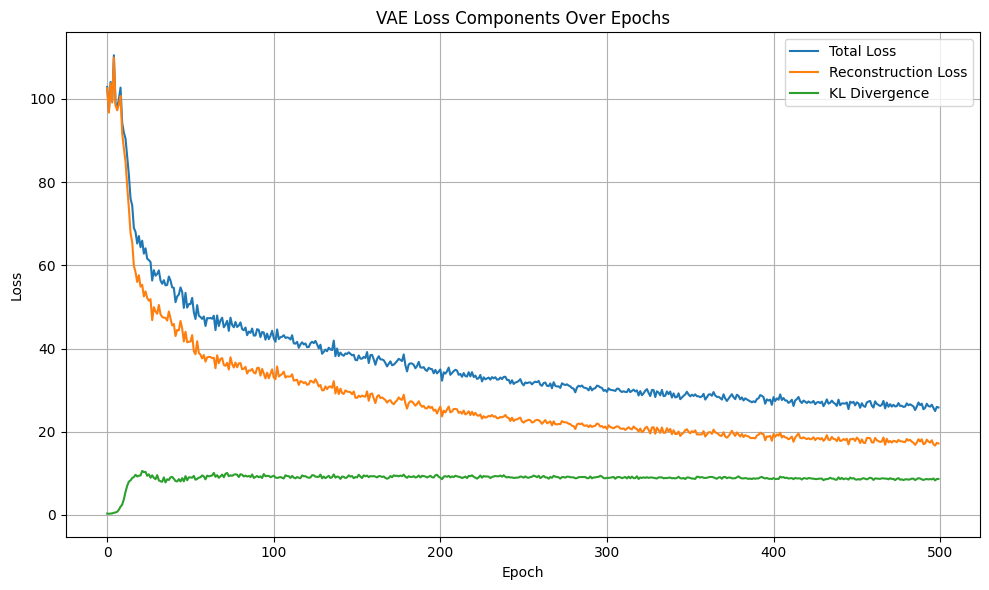

In [7]:
plot_vae_losses(total_loss_hist, recon_loss_hist, kld_loss_hist)

dim of latent mu: (331, 10)


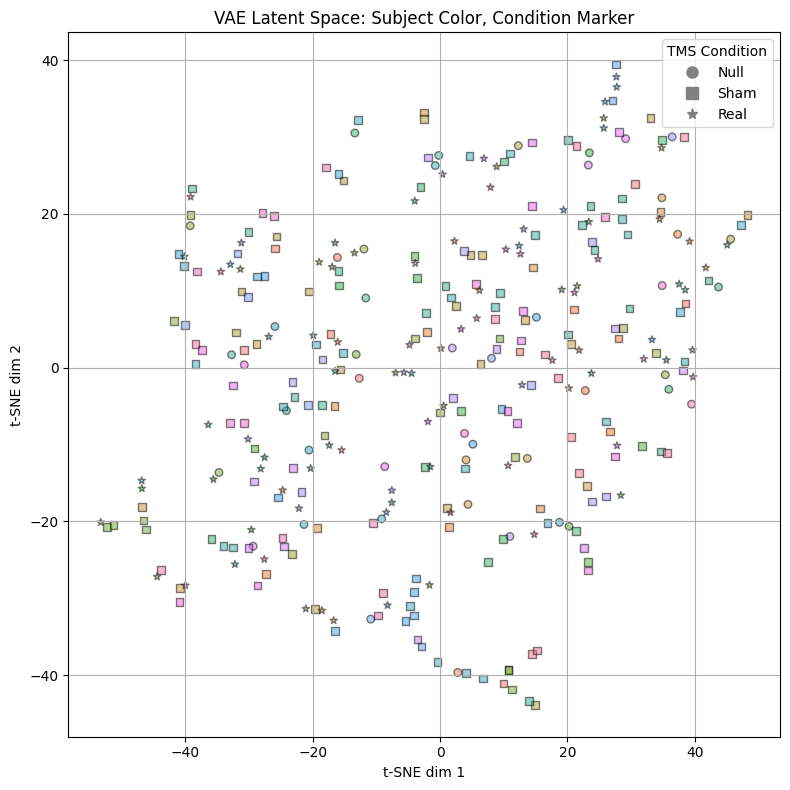

In [9]:
mu_all = get_latent_mu_cvae(model, X_tensor, subject_cond_tensor, device=DEVICE)
# 2d-TSNE
z_2d = TSNE(n_components=2, perplexity=8).fit_transform(mu_all)
plot_latent_embedding_by_condition_and_subject(z_2d, all_tms_type, all_subject_id)

Paired t-test: t = -3.035, p = 0.0040


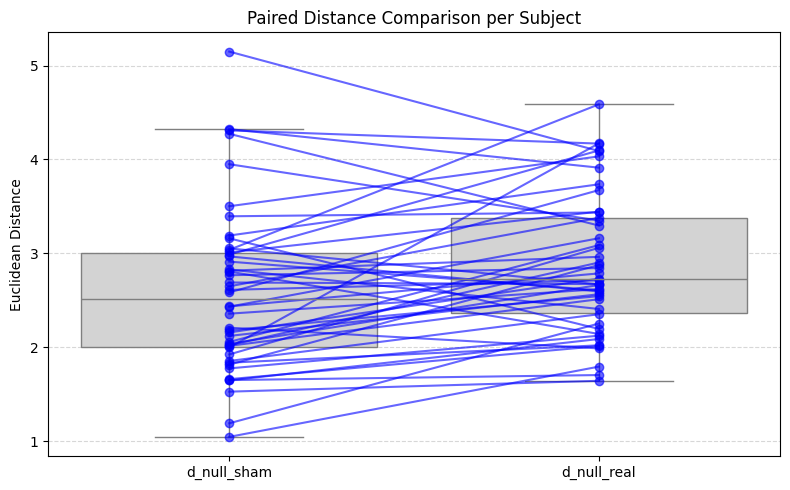

In [10]:
df = compute_condition_distances(mu_all, all_tms_type, all_subject_id, condition_map)

# Paired t-test
t_stat, p_val_t = ttest_rel(df["d_null_sham"], df["d_null_real"])
print(f"Paired t-test: t = {t_stat:.3f}, p = {p_val_t:.4f}")
plot_subject_distance_comparison(df)